# What-If Analysis: Interactive Decision Support

This notebook demonstrates **what-if analysis** using LumiX for quick, interactive exploration of parameter changes and their impact on the optimal solution.

## Problem Description

A manufacturing company wants to quickly assess the impact of various operational changes without running full scenario analysis:

- What if we get more labor hours?
- What if machine capacity is reduced?
- What if we relax minimum production requirements?
- Which resources are most valuable to expand?

## What-If vs Scenario Analysis

| What-If Analysis | Scenario Analysis |
|-----------------|-------------------|
| Quick tactical changes | Strategic planning |
| One parameter at a time | Multiple coordinated changes |
| Minutes to hours | Days to weeks |
| Operational decisions | Business strategy |

## Key Concepts

- **LXWhatIfAnalyzer**: Interactive parameter testing
- **Constraint relaxation**: Testing capacity increases
- **Sensitivity ranges**: Parameter sweeps
- **Bottleneck discovery**: Finding limiting constraints

## 1. Setup and Imports

In [2]:
# Standard library
from dataclasses import dataclass
from typing import List, Dict, Tuple

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# LumiX
from lumix import (
    LXConstraint,
    LXLinearExpression,
    LXModel,
    LXOptimizer,
    LXVariable,
    LXWhatIfAnalyzer,
)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Data Definition

In [3]:
@dataclass
class Product:
    """Product that can be manufactured."""
    id: int
    name: str
    selling_price: float
    unit_cost: float
    labor_hours: float
    machine_hours: float
    material_units: float
    min_production: int


@dataclass
class Resource:
    """Limited resource used in production."""
    id: int
    name: str
    capacity: float


# Sample products
PRODUCTS = [
    Product(1, "Widget A", selling_price=100.0, unit_cost=50.0,
            labor_hours=5.0, machine_hours=3.0, material_units=2.0, min_production=10),
    Product(2, "Widget B", selling_price=150.0, unit_cost=80.0,
            labor_hours=8.0, machine_hours=5.0, material_units=4.0, min_production=5),
    Product(3, "Gadget X", selling_price=200.0, unit_cost=135.0,
            labor_hours=10.0, machine_hours=8.0, material_units=6.0, min_production=8),
    Product(4, "Gadget Y", selling_price=120.0, unit_cost=70.0,
            labor_hours=6.0, machine_hours=4.0, material_units=3.0, min_production=12),
    Product(5, "Premium Z", selling_price=300.0, unit_cost=200.0,
            labor_hours=15.0, machine_hours=12.0, material_units=8.0, min_production=3),
]

# Available resources
RESOURCES = [
    Resource(1, "Labor Hours", capacity=1000.0),
    Resource(2, "Machine Hours", capacity=800.0),
    Resource(3, "Raw Materials", capacity=500.0),
]


def get_resource_usage(product: Product, resource: Resource) -> float:
    """Get resource usage for a product."""
    if resource.name == "Labor Hours":
        return product.labor_hours
    elif resource.name == "Machine Hours":
        return product.machine_hours
    elif resource.name == "Raw Materials":
        return product.material_units
    return 0.0

In [4]:
# Display data
prod_df = pd.DataFrame([{
    'Product': p.name,
    'Price': f'${p.selling_price:.0f}',
    'Cost': f'${p.unit_cost:.0f}',
    'Profit': f'${p.selling_price - p.unit_cost:.0f}',
    'Labor': p.labor_hours,
    'Machine': p.machine_hours,
    'Material': p.material_units,
    'Min Qty': p.min_production
} for p in PRODUCTS])

print("Product Data:")
display(prod_df.set_index('Product'))

print("\nResource Capacities:")
for r in RESOURCES:
    print(f"  {r.name}: {r.capacity:,.0f} units/week")

Product Data:


,Price,Cost,Profit,Labor,Machine,Material,Min Qty
Product,,,,,,,
Widget A,$100,$50,$50,5.0,3.0,2.0,10
Widget B,$150,$80,$70,8.0,5.0,4.0,5
Gadget X,$200,$135,$65,10.0,8.0,6.0,8
Gadget Y,$120,$70,$50,6.0,4.0,3.0,12
Premium Z,$300,$200,$100,15.0,12.0,8.0,3



Resource Capacities:
  Labor Hours: 1,000 units/week
  Machine Hours: 800 units/week
  Raw Materials: 500 units/week


## 3. Build Model and Create Analyzer

In [5]:
def build_production_model() -> LXModel:
    """
    Build production planning model for what-if analysis.
    """
    production = (
        LXVariable[Product, float]("production")
        .continuous()
        .bounds(lower=0)
        .indexed_by(lambda p: p.id)
        .from_data(PRODUCTS)
    )

    model = LXModel[Product]("production_planning").add_variable(production)

    # Objective: Maximize profit
    profit_expr = LXLinearExpression[Product]().add_term(
        production, coeff=lambda p: p.selling_price - p.unit_cost
    )
    model.maximize(profit_expr)

    # Resource constraints
    for resource in RESOURCES:
        usage_expr = LXLinearExpression().add_term(
            production, coeff=lambda p, r=resource: get_resource_usage(p, r)
        )
        model.add_constraint(
            LXConstraint(f"capacity_{resource.name}")
            .expression(usage_expr)
            .le()
            .rhs(resource.capacity)
        )

    # Minimum production constraints
    model.add_constraint(
        LXConstraint[Product]("min_production")
        .expression(LXLinearExpression[Product]().add_term(production, 1.0))
        .ge()
        .rhs(lambda p: float(p.min_production))
        .from_data(PRODUCTS)
        .indexed_by(lambda p: p.name)
    )

    return model


# Build model and create what-if analyzer
model = build_production_model()
optimizer = LXOptimizer().use_solver("ortools")
whatif = LXWhatIfAnalyzer(model, optimizer)

print("Model Summary:")
print(model.summary())

Model Summary:
LXModel: production_planning
  Variable Families: 1
  Constraint Families: 4
  Objective: max



In [6]:
# Get baseline solution
baseline = whatif.get_baseline_solution()

print(f"Baseline Solution:")
print(f"  Status: {baseline.status}")
print(f"  Optimal Profit: ${baseline.objective_value:,.2f}")

2025-12-12 17:18:38 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:18:38 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:18:38 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 9400.0000 | Time: 0.00s


Baseline Solution:
  Status: optimal
  Optimal Profit: $9,400.00


## 4. Basic What-If Tests

In [7]:
# What-if #1: Increase labor hours by 200
print("="*60)
print("WHAT-IF #1: Increase Labor Hours by 200")
print("="*60)

result1 = whatif.increase_constraint_rhs("capacity_Labor Hours", by=200)

print(f"\nOriginal Profit:  ${result1.original_objective:,.2f}")
print(f"New Profit:       ${result1.new_objective:,.2f}")
print(f"Change:           ${result1.delta_objective:,.2f} ({result1.delta_percentage:+.2f}%)")
print(f"\nMarginal Value: ${result1.delta_objective/200:.2f} per labor hour")

2025-12-12 17:18:40 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:18:40 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:18:40 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 11070.0000 | Time: 0.00s


WHAT-IF #1: Increase Labor Hours by 200

Original Profit:  $9,400.00
New Profit:       $11,070.00
Change:           $1,670.00 (+17.77%)

Marginal Value: $8.35 per labor hour


In [8]:
# What-if #2: Decrease machine hours (equipment failure)
print("="*60)
print("WHAT-IF #2: Decrease Machine Hours by 100 (Equipment Failure)")
print("="*60)

result2 = whatif.decrease_constraint_rhs("capacity_Machine Hours", by=100)

print(f"\nOriginal Profit:  ${result2.original_objective:,.2f}")
print(f"New Profit:       ${result2.new_objective:,.2f}")
print(f"Change:           ${result2.delta_objective:,.2f} ({result2.delta_percentage:+.2f}%)")
print(f"\nRisk Assessment: Machine failure would cost ${abs(result2.delta_objective):,.2f}")

2025-12-12 17:18:42 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:18:42 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:18:42 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 9400.0000 | Time: 0.00s


WHAT-IF #2: Decrease Machine Hours by 100 (Equipment Failure)

Original Profit:  $9,400.00
New Profit:       $9,400.00
Change:           $0.00 (+0.00%)

Risk Assessment: Machine failure would cost $0.00


In [9]:
# What-if #3: Tighten raw materials (supply chain issues)
print("="*60)
print("WHAT-IF #3: Tighten Raw Materials by 20% (Supply Chain Issues)")
print("="*60)

result3 = whatif.tighten_constraint("capacity_Raw Materials", by_percent=0.2)

print(f"\nOriginal Profit:  ${result3.original_objective:,.2f}")
print(f"New Profit:       ${result3.new_objective:,.2f}")
print(f"Change:           ${result3.delta_objective:,.2f} ({result3.delta_percentage:+.2f}%)")
print(f"\nSupply Risk: 20% material shortage would cost ${abs(result3.delta_objective):,.2f}")

2025-12-12 17:18:42 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:18:42 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:18:42 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 8570.0000 | Time: 0.00s


WHAT-IF #3: Tighten Raw Materials by 20% (Supply Chain Issues)

Original Profit:  $9,400.00
New Profit:       $8,570.00
Change:           $-830.00 (-8.83%)

Supply Risk: 20% material shortage would cost $830.00


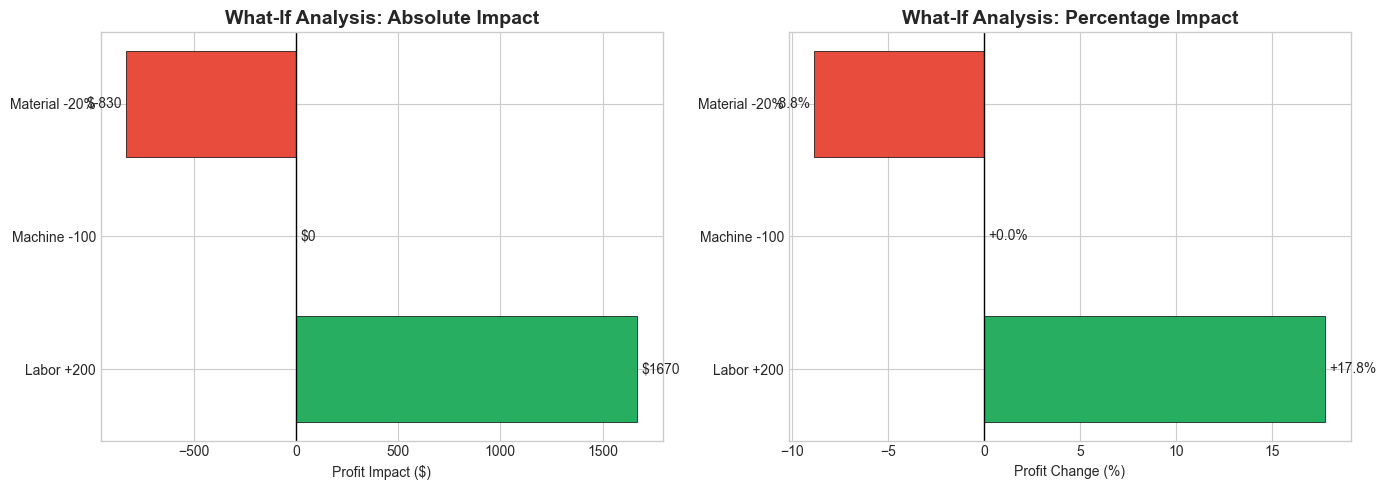

In [10]:
# Visualize what-if results
whatif_results = [
    ("Labor +200", result1.delta_objective, result1.delta_percentage),
    ("Machine -100", result2.delta_objective, result2.delta_percentage),
    ("Material -20%", result3.delta_objective, result3.delta_percentage),
]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: Absolute impact
ax1 = axes[0]
names = [r[0] for r in whatif_results]
impacts = [r[1] for r in whatif_results]
colors = ['#27ae60' if i >= 0 else '#e74c3c' for i in impacts]

bars = ax1.barh(names, impacts, color=colors, edgecolor='black', linewidth=0.5)
ax1.axvline(x=0, color='black', linewidth=1)
ax1.set_xlabel('Profit Impact ($)')
ax1.set_title('What-If Analysis: Absolute Impact', fontsize=14, fontweight='bold')
ax1.bar_label(bars, fmt='$%.0f', padding=3)

# Bar chart: Percentage impact
ax2 = axes[1]
percentages = [r[2] for r in whatif_results]
colors2 = ['#27ae60' if p >= 0 else '#e74c3c' for p in percentages]

bars2 = ax2.barh(names, percentages, color=colors2, edgecolor='black', linewidth=0.5)
ax2.axvline(x=0, color='black', linewidth=1)
ax2.set_xlabel('Profit Change (%)')
ax2.set_title('What-If Analysis: Percentage Impact', fontsize=14, fontweight='bold')
ax2.bar_label(bars2, fmt='%+.1f%%', padding=3)

plt.tight_layout()
plt.show()

## 5. Bottleneck Identification

In [11]:
# Test impact of adding 10 units to each resource
print("="*60)
print("BOTTLENECK IDENTIFICATION")
print("="*60)
print("\nTesting impact of adding 10 units to each resource...")

test_amount = 10.0
bottleneck_data = []

for resource in RESOURCES:
    constraint_name = f"capacity_{resource.name}"
    result = whatif.relax_constraint(constraint_name, by=test_amount)
    improvement_per_unit = result.delta_objective / test_amount
    
    priority = "HIGH" if improvement_per_unit > 1.0 else "MEDIUM" if improvement_per_unit > 0.1 else "LOW"
    
    bottleneck_data.append({
        'Resource': resource.name,
        'Current Capacity': resource.capacity,
        'Test Increase': test_amount,
        'Profit Increase': result.delta_objective,
        'Per Unit Value': improvement_per_unit,
        'Priority': priority
    })

bottleneck_df = pd.DataFrame(bottleneck_data).sort_values('Per Unit Value', ascending=False)
print("\nBottleneck Ranking:")
display(bottleneck_df.set_index('Resource').round(2))

2025-12-12 17:18:47 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:18:47 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:18:47 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 9500.0000 | Time: 0.00s
2025-12-12 17:18:47 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:18:47 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:18:47 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 9400.0000 | Time: 0.00s
2025-12-12 17:18:47 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:18:47 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:18:47 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 9400.0000 | Time: 0.00s


BOTTLENECK IDENTIFICATION

Testing impact of adding 10 units to each resource...

Bottleneck Ranking:


,Current Capacity,Test Increase,Profit Increase,Per Unit Value,Priority
Resource,,,,,
Labor Hours,1000.0,10.0,100.0,10.0,HIGH
Machine Hours,800.0,10.0,0.0,0.0,LOW
Raw Materials,500.0,10.0,0.0,0.0,LOW


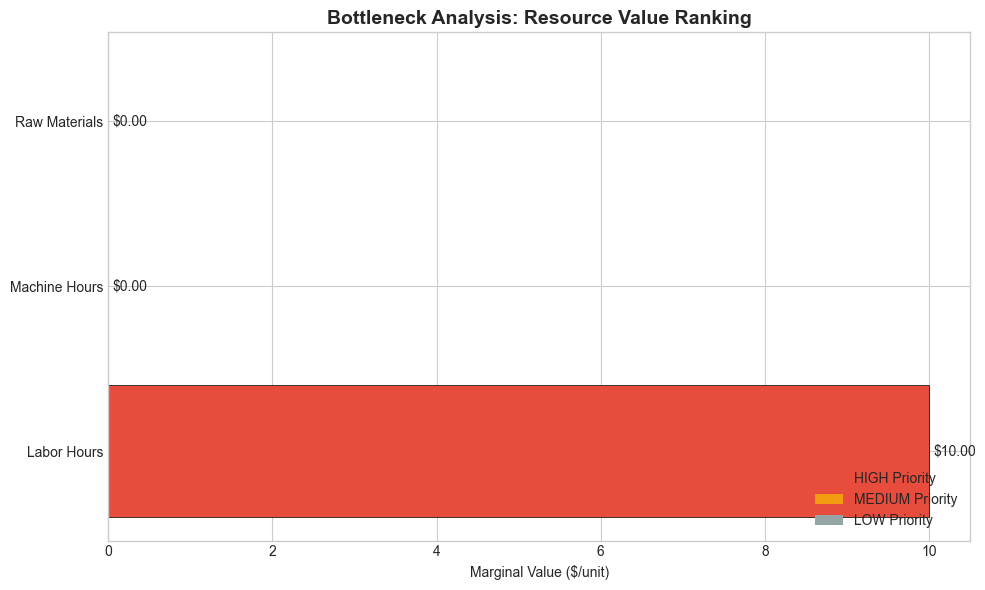


Primary Bottleneck: Labor Hours
Marginal Value: $10.00 per unit
Priority: HIGH


In [12]:
# Bottleneck visualization
fig, ax = plt.subplots(figsize=(10, 6))

resources = bottleneck_df['Resource'].values
values = bottleneck_df['Per Unit Value'].values
priorities = bottleneck_df['Priority'].values

# Color by priority
color_map = {'HIGH': '#e74c3c', 'MEDIUM': '#f39c12', 'LOW': '#95a5a6'}
colors = [color_map[p] for p in priorities]

bars = ax.barh(resources, values, color=colors, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Marginal Value ($/unit)')
ax.set_title('Bottleneck Analysis: Resource Value Ranking', fontsize=14, fontweight='bold')
ax.bar_label(bars, fmt='$%.2f', padding=3)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='HIGH Priority'),
    Patch(facecolor='#f39c12', label='MEDIUM Priority'),
    Patch(facecolor='#95a5a6', label='LOW Priority')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Identify primary bottleneck
top_bottleneck = bottleneck_df.iloc[0]
print(f"\nPrimary Bottleneck: {top_bottleneck['Resource']}")
print(f"Marginal Value: ${top_bottleneck['Per Unit Value']:.2f} per unit")
print(f"Priority: {top_bottleneck['Priority']}")

## 6. Sensitivity Range Analysis

In [13]:
# Analyze labor capacity sensitivity
print("="*60)
print("SENSITIVITY RANGE: Labor Capacity (700 - 1300 hours)")
print("="*60)

labor_range = whatif.sensitivity_range(
    "capacity_Labor Hours", 
    min_value=700, 
    max_value=1300, 
    num_points=13
)

# Create dataframe
labor_sensitivity = []
baseline_profit = baseline.objective_value

for labor, profit in labor_range:
    delta = profit - baseline_profit
    delta_pct = (delta / baseline_profit) * 100 if baseline_profit != 0 else 0
    labor_sensitivity.append({
        'Labor Hours': labor,
        'Profit': profit,
        'vs Baseline ($)': delta,
        'vs Baseline (%)': delta_pct
    })

sens_df = pd.DataFrame(labor_sensitivity)
print("\nLabor Capacity Sensitivity:")
display(sens_df.round(2))

2025-12-12 17:18:53 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:18:53 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:18:53 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 6400.0000 | Time: 0.00s
2025-12-12 17:18:53 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:18:53 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:18:53 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 6900.0000 | Time: 0.00s
2025-12-12 17:18:53 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:18:53 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:18:53 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 7400.0000 | Time: 0.00s
2025-12-12 17:18:53 - lumix.optimizer - INFO - Created model 'production_planning' wi

SENSITIVITY RANGE: Labor Capacity (700 - 1300 hours)

Labor Capacity Sensitivity:


,Labor Hours,Profit,vs Baseline ($),vs Baseline (%)
0,700.0,6400.0,-3000.0,-31.91
1,750.0,6900.0,-2500.0,-26.60
2,800.0,7400.0,-2000.0,-21.28
3,850.0,7900.0,-1500.0,-15.96
4,900.0,8400.0,-1000.0,-10.64
5,950.0,8900.0,-500.0,-5.32
6,1000.0,9400.0,0.0,0.00
7,1050.0,9900.0,500.0,5.32
8,1100.0,10400.0,1000.0,10.64
9,1150.0,10900.0,1500.0,15.96


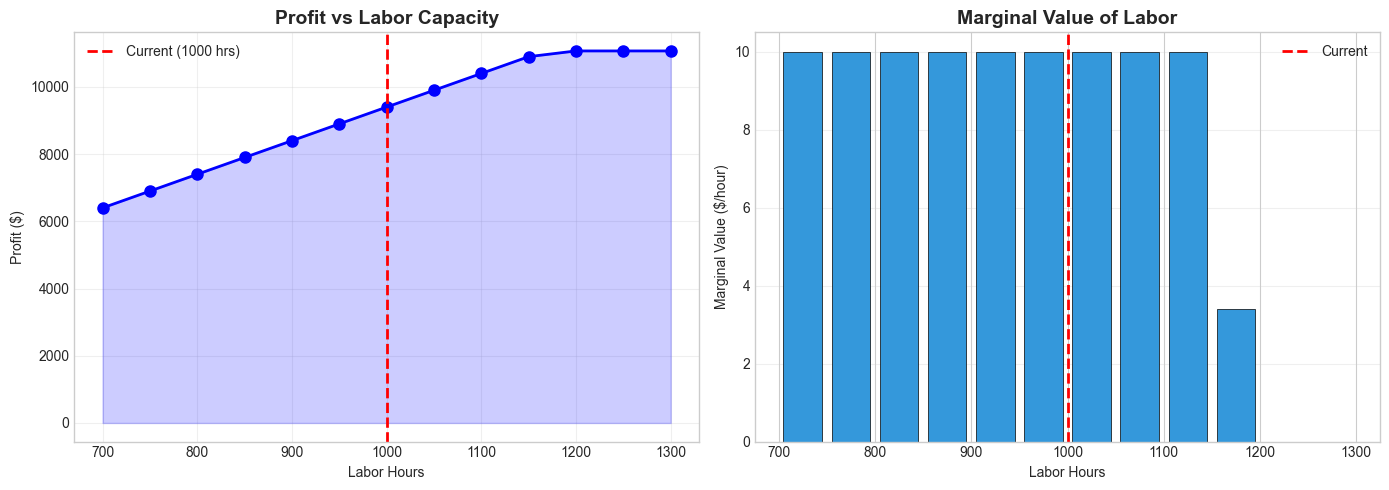

In [14]:
# Sensitivity curve visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

labor_values = [r[0] for r in labor_range]
profit_values = [r[1] for r in labor_range]

# Profit vs Labor curve
ax1 = axes[0]
ax1.plot(labor_values, profit_values, 'b-o', markersize=8, linewidth=2)
ax1.fill_between(labor_values, profit_values, alpha=0.2, color='blue')
ax1.axvline(x=1000, color='red', linestyle='--', linewidth=2, label='Current (1000 hrs)')
ax1.set_xlabel('Labor Hours')
ax1.set_ylabel('Profit ($)')
ax1.set_title('Profit vs Labor Capacity', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Marginal value curve (derivative)
ax2 = axes[1]
marginal_values = []
for i in range(len(labor_range) - 1):
    delta_labor = labor_range[i+1][0] - labor_range[i][0]
    delta_profit = labor_range[i+1][1] - labor_range[i][1]
    marginal = delta_profit / delta_labor if delta_labor != 0 else 0
    mid_point = (labor_range[i][0] + labor_range[i+1][0]) / 2
    marginal_values.append((mid_point, marginal))

mid_points = [m[0] for m in marginal_values]
margins = [m[1] for m in marginal_values]

bars = ax2.bar(mid_points, margins, width=40, color='#3498db', edgecolor='black', linewidth=0.5)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.axvline(x=1000, color='red', linestyle='--', linewidth=2, label='Current')
ax2.set_xlabel('Labor Hours')
ax2.set_ylabel('Marginal Value ($/hour)')
ax2.set_title('Marginal Value of Labor', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [15]:
# Multi-resource sensitivity comparison
print("="*60)
print("MULTI-RESOURCE SENSITIVITY COMPARISON")
print("="*60)

# Test range for each resource
resource_sensitivities = {}

for resource in RESOURCES:
    constraint_name = f"capacity_{resource.name}"
    base_capacity = resource.capacity
    
    # Test from 70% to 130% of base capacity
    sensitivity = whatif.sensitivity_range(
        constraint_name,
        min_value=base_capacity * 0.7,
        max_value=base_capacity * 1.3,
        num_points=7
    )
    
    # Normalize to percentage of base
    normalized = [(cap / base_capacity * 100, profit) for cap, profit in sensitivity]
    resource_sensitivities[resource.name] = normalized

2025-12-12 17:18:57 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:18:57 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:18:57 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 6400.0000 | Time: 0.00s
2025-12-12 17:18:57 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:18:57 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:18:57 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 7400.0000 | Time: 0.00s
2025-12-12 17:18:57 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:18:57 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:18:57 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 8400.0000 | Time: 0.00s
2025-12-12 17:18:57 - lumix.optimizer - INFO - Created model 'production_planning' wi

MULTI-RESOURCE SENSITIVITY COMPARISON


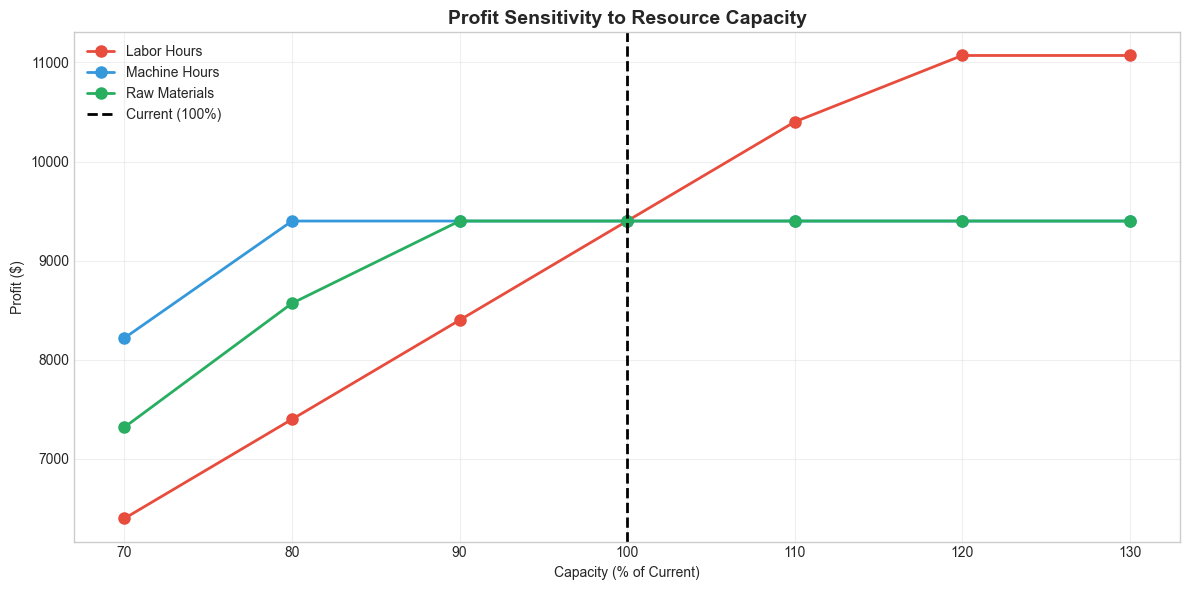

In [16]:
# Plot multi-resource sensitivity
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#e74c3c', '#3498db', '#27ae60']

for i, (name, data) in enumerate(resource_sensitivities.items()):
    percentages = [d[0] for d in data]
    profits = [d[1] for d in data]
    ax.plot(percentages, profits, 'o-', markersize=8, linewidth=2, 
            color=colors[i], label=name)

ax.axvline(x=100, color='black', linestyle='--', linewidth=2, label='Current (100%)')
ax.set_xlabel('Capacity (% of Current)')
ax.set_ylabel('Profit ($)')
ax.set_title('Profit Sensitivity to Resource Capacity', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Investment Option Comparison

In [17]:
# Define investment options
print("="*60)
print("INVESTMENT OPTION COMPARISON")
print("="*60)

investment_options = [
    ("capacity_Labor Hours", "increase", 100),
    ("capacity_Labor Hours", "increase", 200),
    ("capacity_Labor Hours", "increase", 300),
    ("capacity_Machine Hours", "increase", 100),
    ("capacity_Machine Hours", "increase", 200),
    ("capacity_Raw Materials", "increase", 100),
]

# Compare all options
results = whatif.compare_changes(investment_options)

investment_data = []
for (constraint, _, amount), result in zip(investment_options, results):
    resource_name = constraint.replace('capacity_', '')
    roi_per_unit = result.delta_objective / amount if amount != 0 else 0
    
    investment_data.append({
        'Resource': resource_name,
        'Increase': f'+{amount}',
        'Profit Change': result.delta_objective,
        'Change %': result.delta_percentage,
        'ROI/Unit': roi_per_unit
    })

investment_df = pd.DataFrame(investment_data)
print("\nInvestment Options:")
display(investment_df.round(2))

2025-12-12 17:19:03 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:19:03 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:19:03 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 10400.0000 | Time: 0.00s
2025-12-12 17:19:03 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:19:03 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:19:03 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 11070.0000 | Time: 0.00s
2025-12-12 17:19:03 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:19:03 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:19:03 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 11070.0000 | Time: 0.00s
2025-12-12 17:19:03 - lumix.optimizer - INFO - Created model 'production_planning'

INVESTMENT OPTION COMPARISON

Investment Options:


,Resource,Increase,Profit Change,Change %,ROI/Unit
0,Labor Hours,+100,1000.0,10.64,10.00
1,Labor Hours,+200,1670.0,17.77,8.35
2,Labor Hours,+300,1670.0,17.77,5.57
3,Machine Hours,+100,0.0,0.00,0.00
4,Machine Hours,+200,0.0,0.00,0.00
5,Raw Materials,+100,0.0,0.00,0.00


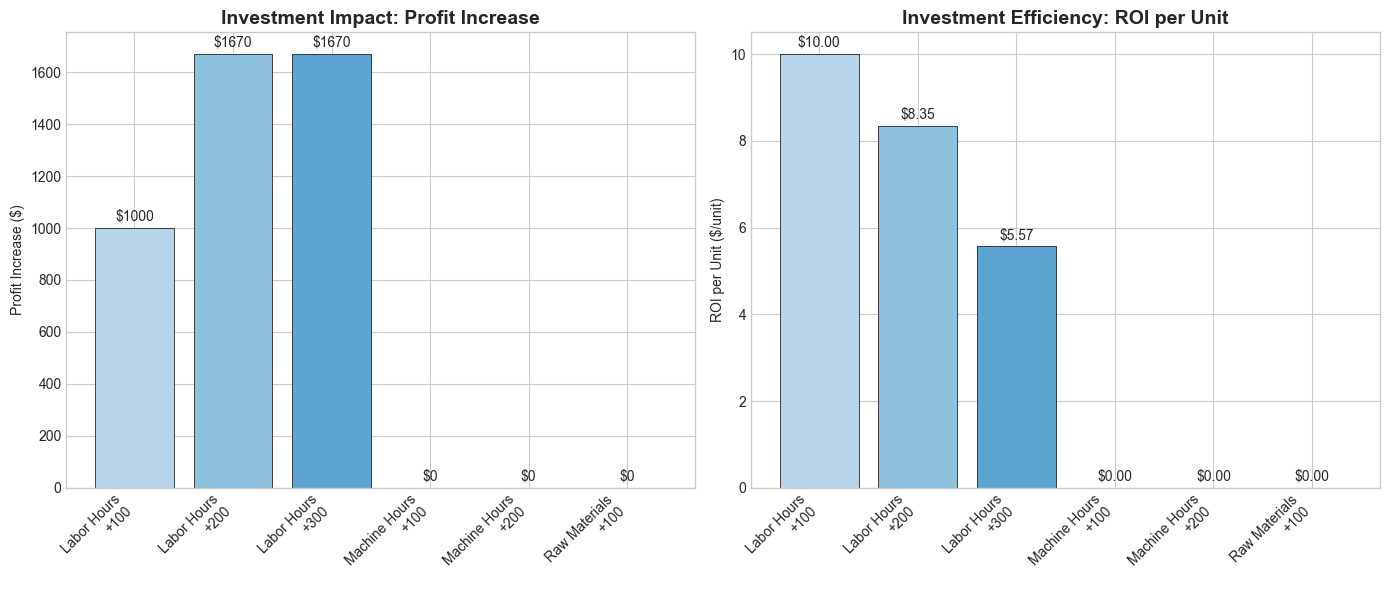

In [18]:
# Investment comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Profit increase by option
ax1 = axes[0]
labels = [f"{d['Resource']}\n{d['Increase']}" for d in investment_data]
profits = [d['Profit Change'] for d in investment_data]

colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(labels)))
bars = ax1.bar(labels, profits, color=colors, edgecolor='black', linewidth=0.5)
ax1.set_ylabel('Profit Increase ($)')
ax1.set_title('Investment Impact: Profit Increase', fontsize=14, fontweight='bold')
ax1.bar_label(bars, fmt='$%.0f', padding=3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# ROI per unit
ax2 = axes[1]
rois = [d['ROI/Unit'] for d in investment_data]

bars2 = ax2.bar(labels, rois, color=colors, edgecolor='black', linewidth=0.5)
ax2.set_ylabel('ROI per Unit ($/unit)')
ax2.set_title('Investment Efficiency: ROI per Unit', fontsize=14, fontweight='bold')
ax2.bar_label(bars2, fmt='$%.2f', padding=3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [19]:
# Best investment recommendation
best_idx = investment_df['Profit Change'].idxmax()
best_investment = investment_df.iloc[best_idx]

best_roi_idx = investment_df['ROI/Unit'].idxmax()
best_roi_investment = investment_df.iloc[best_roi_idx]

print("="*60)
print("INVESTMENT RECOMMENDATIONS")
print("="*60)

print(f"\n1. HIGHEST PROFIT IMPACT:")
print(f"   Resource: {best_investment['Resource']}")
print(f"   Increase: {best_investment['Increase']}")
print(f"   Profit Impact: ${best_investment['Profit Change']:,.2f}")

print(f"\n2. HIGHEST ROI EFFICIENCY:")
print(f"   Resource: {best_roi_investment['Resource']}")
print(f"   Increase: {best_roi_investment['Increase']}")
print(f"   ROI per Unit: ${best_roi_investment['ROI/Unit']:.2f}")

INVESTMENT RECOMMENDATIONS

1. HIGHEST PROFIT IMPACT:
   Resource: Labor Hours
   Increase: +200
   Profit Impact: $1,670.00

2. HIGHEST ROI EFFICIENCY:
   Resource: Labor Hours
   Increase: +100
   ROI per Unit: $10.00


## 8. Interactive Decision Dashboard

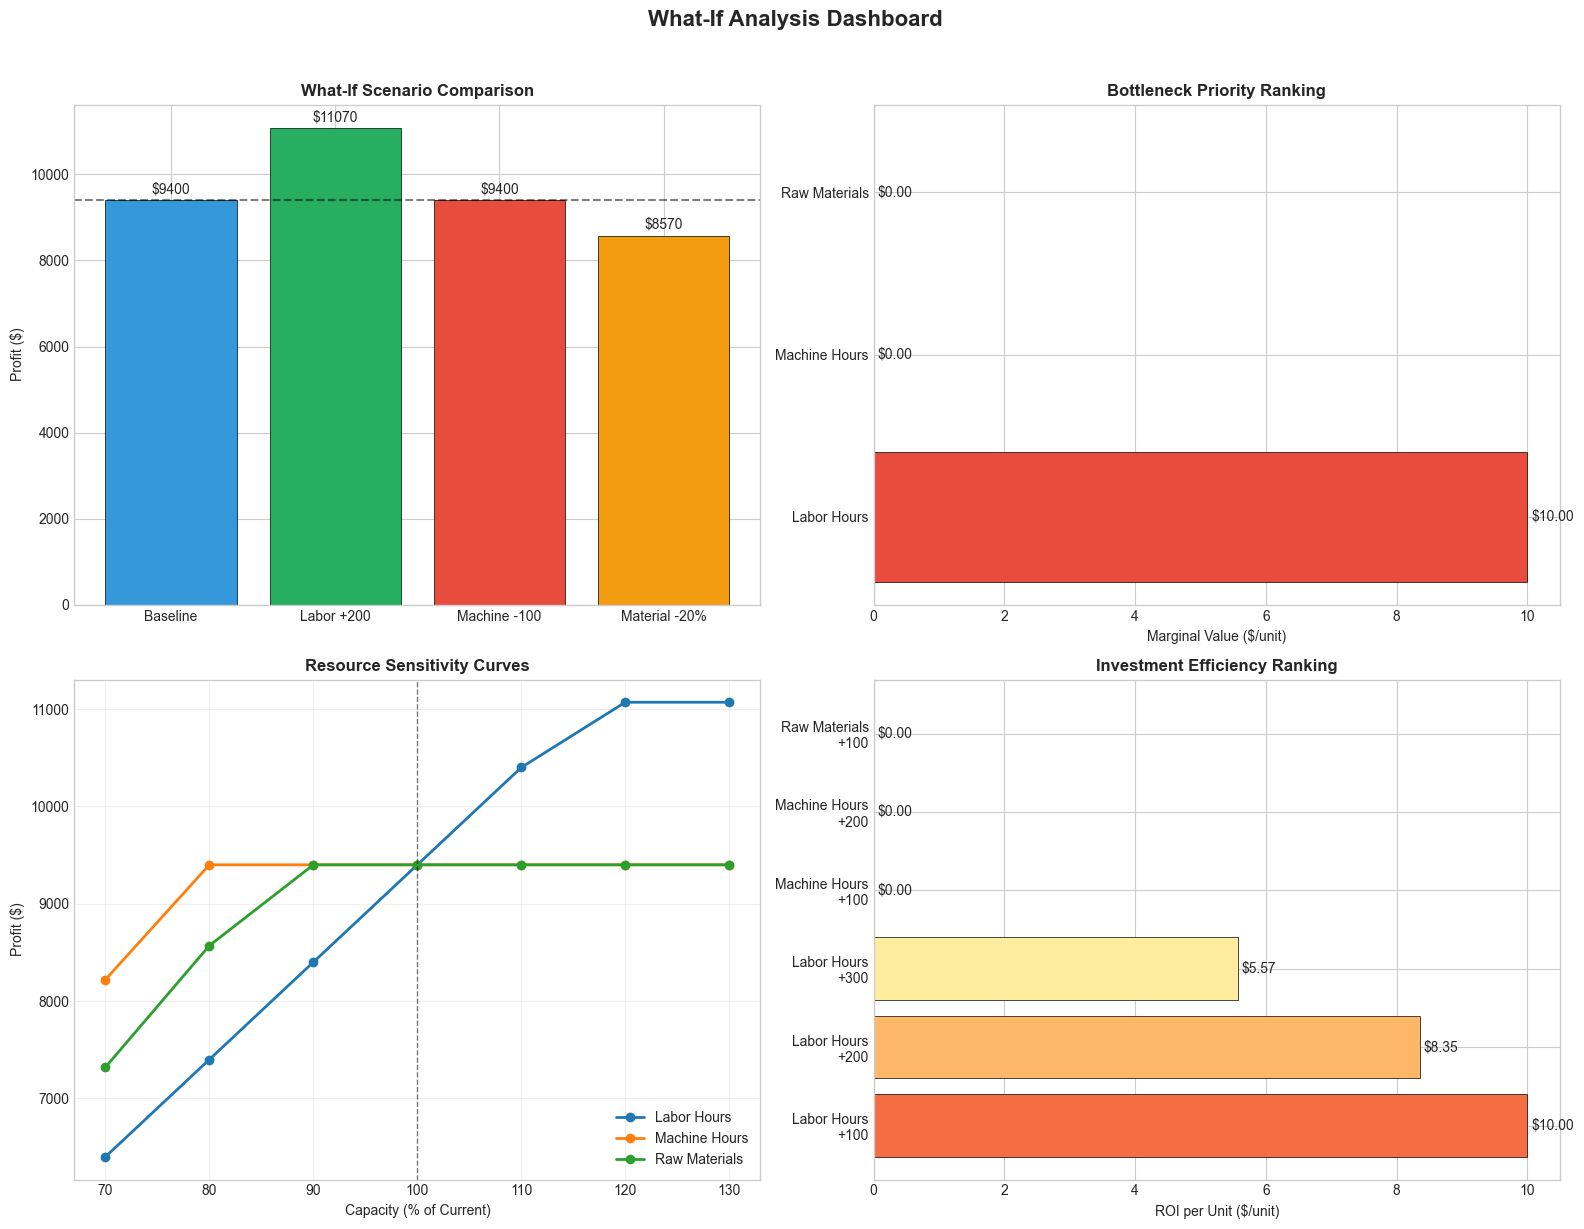

In [20]:
# Create comprehensive dashboard
fig = plt.figure(figsize=(16, 12))

# 1. Baseline vs scenarios
ax1 = fig.add_subplot(2, 2, 1)
scenarios = ['Baseline', 'Labor +200', 'Machine -100', 'Material -20%']
profits = [
    baseline.objective_value,
    result1.new_objective,
    result2.new_objective,
    result3.new_objective
]
colors = ['#3498db', '#27ae60', '#e74c3c', '#f39c12']
bars = ax1.bar(scenarios, profits, color=colors, edgecolor='black', linewidth=0.5)
ax1.set_ylabel('Profit ($)')
ax1.set_title('What-If Scenario Comparison', fontsize=12, fontweight='bold')
ax1.bar_label(bars, fmt='$%.0f', padding=3)
ax1.axhline(y=baseline.objective_value, color='black', linestyle='--', alpha=0.5)

# 2. Bottleneck ranking
ax2 = fig.add_subplot(2, 2, 2)
resources = bottleneck_df['Resource'].values
values = bottleneck_df['Per Unit Value'].values
priorities = bottleneck_df['Priority'].values
color_map = {'HIGH': '#e74c3c', 'MEDIUM': '#f39c12', 'LOW': '#95a5a6'}
colors2 = [color_map[p] for p in priorities]
bars2 = ax2.barh(resources, values, color=colors2, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Marginal Value ($/unit)')
ax2.set_title('Bottleneck Priority Ranking', fontsize=12, fontweight='bold')
ax2.bar_label(bars2, fmt='$%.2f', padding=3)

# 3. Sensitivity curves
ax3 = fig.add_subplot(2, 2, 3)
for name, data in resource_sensitivities.items():
    percentages = [d[0] for d in data]
    profits = [d[1] for d in data]
    ax3.plot(percentages, profits, 'o-', markersize=6, linewidth=2, label=name)
ax3.axvline(x=100, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_xlabel('Capacity (% of Current)')
ax3.set_ylabel('Profit ($)')
ax3.set_title('Resource Sensitivity Curves', fontsize=12, fontweight='bold')
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)

# 4. Investment ROI
ax4 = fig.add_subplot(2, 2, 4)
inv_labels = [f"{d['Resource']}\n{d['Increase']}" for d in investment_data]
rois = [d['ROI/Unit'] for d in investment_data]
colors4 = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(inv_labels)))
bars4 = ax4.barh(inv_labels, rois, color=colors4, edgecolor='black', linewidth=0.5)
ax4.set_xlabel('ROI per Unit ($/unit)')
ax4.set_title('Investment Efficiency Ranking', fontsize=12, fontweight='bold')
ax4.bar_label(bars4, fmt='$%.2f', padding=3)

plt.suptitle('What-If Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 9. Key Insights

### What-If Analysis Benefits
- **Speed**: Quick answers to operational questions
- **Simplicity**: Test one parameter at a time
- **Interactivity**: Immediate feedback for decisions
- **Risk Assessment**: Quantify downside scenarios

### LXWhatIfAnalyzer Methods
- `increase_constraint_rhs()`: Add to constraint capacity
- `decrease_constraint_rhs()`: Reduce constraint capacity
- `relax_constraint()`: Make constraint easier to satisfy
- `tighten_constraint()`: Make constraint harder to satisfy
- `sensitivity_range()`: Test parameter over a range
- `compare_changes()`: Evaluate multiple options

### Best Practices
1. Start with baseline solution
2. Test individual parameters first
3. Use sensitivity ranges to find breakpoints
4. Compare ROI per unit for investment decisions
5. Consider both positive and negative scenarios

## 10. Extensions & Exercises

1. **Break-even analysis**: Find the capacity where profit becomes zero
2. **Multi-parameter changes**: Test simultaneous changes
3. **Cost-benefit**: Add investment costs to ROI calculations
4. **Time-series**: Analyze seasonal capacity variations
5. **Automated alerts**: Trigger warnings when capacity drops below threshold